In [1]:
%matplotlib inline
import os
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils import data

import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms

import time
import shutil

import cv2
import imutils
import sys

In [2]:
print(os.listdir("hand"))

['train', 'valid']


In [17]:
base_path = "hand_dataset"
train_path = base_path + "/train"
valid_path = base_path + "/valid"

In [10]:
class AdaptiveConcatPool2d(nn.Module):
    "Layer that concats `AdaptiveAvgPool2d` and `AdaptiveMaxPool2d`."
    def __init__(self, sz:int=None):
        "Output will be 2*sz or 2 if sz is None"
        super().__init__()
        sz = sz or 1
        self.ap,self.mp = nn.AdaptiveAvgPool2d(sz), nn.AdaptiveMaxPool2d(sz)
    def forward(self, x): return torch.cat([self.mp(x), self.ap(x)], 1)

class Lambda(nn.Module):
    "An easy way to create a pytorch layer for a simple `func`."
    def __init__(self, func):
        "create a layer that simply calls `func` with `x`"
        super().__init__()
        self.func=func

    def forward(self, x): return self.func(x)
    
def Flatten()->torch.Tensor:
    "Flattens `x` to a single dimension, often used at the end of a model."
    return Lambda(lambda x: x.view((x.size(0), -1)))


class HandNetwork(nn.Module):
    def __init__(self, resnet, clazz):
        super(HandNetwork, self).__init__()
        self.pool_size = 1
        self.resnet = resnet
        
        # out_channels multiple by pool size and multiply by 2
        # multiply by 2 is get from torch cat of AdaptiveAvgPool2d and AdaptiveMaxPool2d
        in_features = self.get_last_layer_out_channels() * self.pool_size*self.pool_size*2
        
        self.resnet.avgpool = nn.Sequential(
            AdaptiveConcatPool2d(self.pool_size),
            Flatten()
        )
        
        self.resnet.fc = nn.Sequential(
            nn.BatchNorm1d(in_features),
            nn.Dropout(0.5),
            nn.Linear(in_features, in_features//2),
            nn.ReLU(inplace=True),
            
            nn.BatchNorm1d(in_features//2),
            nn.Dropout(0.3),
            nn.Linear(in_features//2, in_features//4),
            nn.ReLU(inplace=True),
            
            nn.BatchNorm1d(in_features//4),
            nn.Dropout(0.2),
            nn.Linear(in_features//4, clazz),
        )
        
    def forward(self, x):
        x = self.resnet(x)
        return x
        
    def get_last_layer_out_channels(self):
        if len(self.resnet.layer4) >=3:
            if type(self.resnet.layer4[2]) == torchvision.models.resnet.BasicBlock:
                return self.resnet.layer4[2].conv2.out_channels
            elif type(self.resnet.layer4[2]) == torchvision.models.resnet.Bottleneck:
                return self.resnet.layer4[2].conv3.out_channels
            else:
                return 0
        else:
            if type(self.resnet.layer4[1]) == torchvision.models.resnet.BasicBlock:
                return self.resnet.layer4[1].conv2.out_channels
            elif type(self.resnet.layer4[1]) == torchvision.models.resnet.Bottleneck:
                return self.resnet.layer4[1].conv3.out_channels
            else:
                return 0
            
    def freeze(self):
        for param in self.resnet.parameters():
            param.require_grad = False
        for param in self.resnet.fc.parameters():
            param.require_grad= True
            
    def unfreeze(self):
        for param in self.resnet.parameters():
            param.require_grad = True
            

In [18]:
# TODO: Write a function that loads a checkpoint and rebuilds the model
def load_network(filename):
    if os.path.isfile(filename): 
        checkpoint = torch.load(filename, map_location='cpu')
        resnet = torchvision.models.resnet18(pretrained=True)
        clazz = checkpoint['total_clazz']
        model = HandNetwork(resnet, clazz)
        model.load_state_dict(checkpoint['state_dict'])
        return model
    else:
        return None
    

def load_checkpoint(filename):
    if os.path.isfile(filename): 
        checkpoint = torch.load(filename, map_location='cpu')
        return checkpoint
    else:
        return None
    
model = load_network('model/model_best.pth')
model.cpu()
checkpoint = load_checkpoint('model/model_best.pth')

In [19]:
import PIL
import PIL.Image
import torch.nn.functional as F

def idx_to_class(class_to_idx):
    idx2class = {}
    for key, val in class_to_idx.items():
        dt = {val:key}
        idx2class.update(dt)
    return idx2class

def get_hand_number(classes, class_to_idx):
    idx2class = idx_to_class(class_to_idx)
    nclass = classes.data.squeeze().numpy().tolist()
    name = []
    for key in nclass:
        name.append(idx2class[key])
    return nclass, name
    

def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    im = PIL.Image.open(image)
    mean_val, std_val = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
    do_transforms =  transforms.Compose([
        transforms.Resize(224),
#         transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean_val,std_val)
    ])
    im_tfmt = do_transforms(im)
    im_add_batch = im_tfmt.view(1, im_tfmt.shape[0], im_tfmt.shape[1], im_tfmt.shape[2])
    return im_add_batch


def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    image = process_image(image_path)
    model.eval()
    model = model.cpu()
    with torch.no_grad():
        output = model.forward(image)
        output = F.log_softmax(output, dim=1)
        ps = torch.exp(output)
        result = ps.topk(topk, dim=1, largest=True, sorted=True)
        
    return result
    

In [20]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

tensor([[8.9277e-01, 1.0543e-01, 1.2197e-03, 3.3395e-04, 1.0277e-04]])
tensor([[0, 1, 2, 3, 4]])
[0, 1, 2, 3, 4]
['0', '1', '2', '3', '4']


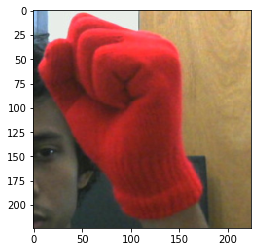

In [21]:
image_file = valid_path + "/0/r_0_l_04.jpg"
out_im = process_image(image_file)
imshow(out_im.squeeze())

probs, classes = predict(image_file, model, topk=5)
class_index, class_name = get_hand_number(classes, checkpoint['class_to_idx'])

print(probs)
print(classes)
print(class_index)
print(class_name)

In [22]:
def view_classify(img_path, label_idx, prob, classes, class_to_idx):
    ''' Function for viewing an image and it's predicted classes.
    '''
    idx2class = idx_to_class(class_to_idx)
    img = np.asarray(PIL.Image.open(img_path))
    ps = prob.data.numpy().squeeze().tolist()
    fig, (ax1, ax2) = plt.subplots(figsize=(10,10), ncols=2)
    ax1.imshow(img.squeeze())
    ax1.set_title(idx2class[label_idx])
    ax1.axis('off')
    
    ax2.barh(np.arange(5), ps)
    ax2.set_aspect(0.2)
    ax2.set_yticks(np.arange(5))
    
    
    class_idx, class_name = get_hand_number(classes, class_to_idx)
    ax2.set_yticklabels(class_name, size='large');
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()

tensor([[9.9940e-01, 3.7941e-04, 9.8760e-05, 7.3362e-05, 3.2301e-05]])
tensor([[2, 6, 4, 1, 5]])
[2, 6, 4, 1, 5]
['2', 'b', '4', '1', '5']
CPU times: user 1 s, sys: 16 ms, total: 1.02 s
Wall time: 835 ms


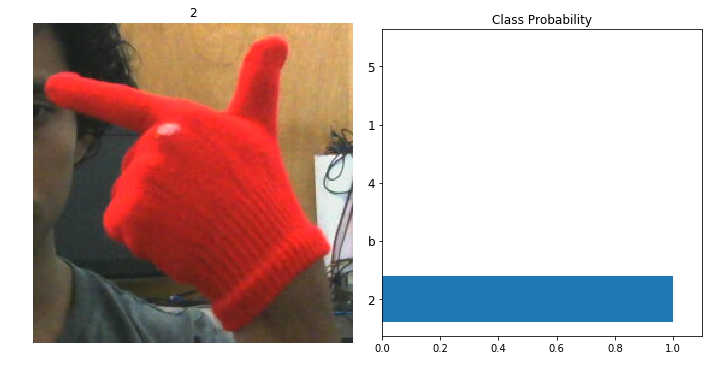

In [16]:
%%time
image_file = valid_path + "/2/r_2_l_21.jpg"
probs, classes = predict(image_file, model)
class_index, class_name = get_hand_number(classes, checkpoint['class_to_idx'])
print(probs)
print(classes)
print(class_index)
print(class_name)
view_classify(image_file, 2, probs, classes, checkpoint['class_to_idx'])

In [63]:
def autocenter(bbox, pad={'r':100, 'l':50, 't':50, 'b':100}, ratio=1):
    x,y,w,h=bbox
    ratio_real = h/w
    if w>h:
        hn = int(w * ratio)
        wn = w
    else:
        hn = h
        wn = int(h * ratio)
    
    yn=(y + (h//2)) - (hn//2)
    xn=(x + (w//2)) - (wn//2)
    xn = xn - pad['l']
    yn = yn - pad['t']
    hn = hn + pad['b']
    wn = wn + pad['r']
    
    return (xn, yn, wn, hn)

In [64]:
cap = cv2.VideoCapture(0)

while True: 
    _, frame = cap.read()
    mask = get_mask(frame)
    large_contours = get_large_contour(mask)
#     cropped_image = get_cropped_image(frame, large_contours)
#     print(large_contours)
# draw contours
#     cv2.drawContours(frame, large_contours, -1, (0, 255, 0), 2)
#     sys.stdout.write('\r count: '+str(len(large_contours)))   
    for idx in range(len(large_contours)):
        bbox = cv2.boundingRect(large_contours[idx])
        x,y,w,h=bbox
        x1,y1,w1,h1=autocenter(bbox)
#         cv2.rectangle(frame, (x,y), (x+w, y+h), (0,0,255),2)
        cv2.rectangle(frame, (x1,y1), (x1+w1, y1+h1), (0,255,0),2)
#         crop_img = frame[y1:y1+h1, x1:x1+w1]
#         crop_resize = cv2.resize(crop_img, (224,224))
#         plt.imshow(crop_img);plt.show()
#         print(type(crop_img)==None)
#         if crop_img.all():
#             cv2.imshow('frame2', crop_img)
#         if y1+h1>y1 and x1+w1>x1:
#             plt.imshow(frame[y1:y1+h1, x1:x1+w1])
#             cv2.imshow('frame1', frame[y1:y1+h1,x1:x1+w1])
        
#     cv2.imshow('frame', cropped_image)
    cv2.imshow('frame', frame)
                
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
    
cap.release()
cv2.destroyAllWindows()


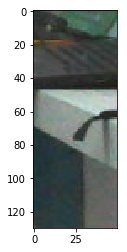

In [55]:
frame = cv2.imread('r_5.jpg', cv2.IMREAD_COLOR)
mask = get_mask(frame)
im, cntr, hierarcy = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# find contours of large enough area
min_coin_area = 600
large_contours = [cnt for cnt in cntr if cv2.contourArea(cnt) > min_coin_area]
# print(large_contours)
# draw contours
# cv2.drawContours(frame, large_contours, -1, (0, 255, 0), 2)
#     sys.stdout.write('\r count: '+str(len(large_contours)))
    
for idx in range(len(large_contours)):
    bbox = cv2.boundingRect(large_contours[idx])
    x,y,w,h=bbox
    x1,y1,w1,h1=autocenter(bbox)
#         cv2.rectangle(frame, (x,y), (x+w, y+h), (0,0,255),2)
    rect = cv2.rectangle(frame, (x1,y1), (x1+w1, y1+h1), (0,255,0),2)
    crop_img = rect[y1:y1+h1, x1:x1+w1]
#     img = np.asarray(crop_img)
#     print(img)
#         if y1+h1>y1 and x1+w1>x1:
#             plt.imshow(frame[y1:y1+h1, x1:x1+w1])
#             cv2.imshow('frame1', frame[y1:y1+h1,x1:x1+w1])      

plt.imshow(crop_img, cmap='gray')

In [21]:
cv2.resize

<function resize>

In [16]:
def crop_bbox(frame, bbox):
    x1,y1,w1,h1=bbox
    return frame[y1:y1+h1, x1:x1+w1]

In [34]:
def draw_rectangle(frame,bbox):
    x1,y1,w1,h1=autocenter(bbox)
    cv2.rectangle(frame, (x1,y1), (x1+w1, y1+h1), (0,255,0),2)
    return frame

In [54]:
def get_mask(frame):
    blurred_frame = cv2.GaussianBlur(frame, (15, 15), 10)
    hsv = cv2.cvtColor(blurred_frame, cv2.COLOR_BGR2HSV)

    lower = np.array([0, 200, 50])
    upper = np.array([255, 255, 255])

    mask = cv2.inRange(hsv, lower, upper)
    mask_inv = cv2.bitwise_not(mask)
    return mask_inv

In [19]:
def get_large_contour(mask):
    im, cntr, hierarcy = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
# find contours of large enough area
    min_coin_area = 600
    large_contours = [cnt for cnt in cntr if cv2.contourArea(cnt) > min_coin_area]
    return large_contours

In [23]:
def get_cropped_image(frame, large_contours):
    for idx in range(len(large_contours)):
        bbox = cv2.boundingRect(large_contours[idx])
        rect = draw_rectangle(frame,bbox)
        crop_bbox(frame, rect)
    return frame